## Mean reversion Strategy based on linear decay of SP500 stock prices (close)
This is a very simple signal where stocks are ranked in terms over their linear decay on the past 20 trading days.

In [ ]:
import pandas as pd
import numpy as np
from data_master import DataMaster
from utils import func
from scipy.stats import norm
master = DataMaster()
from utils.func import center
from quantstats.stats import sharpe
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
market_data = pd.read_parquet('data/US/mkt_data.pq')
balance_sheet = pd.read_parquet('data/US/balance_sheets.pq')
GICS = pd.read_parquet('data/US/GICS.pq')
P = pd.read_parquet('data/US/universe_table.pq')
R = market_data['close'].unstack().reindex_like(P).pct_change()
market_data.dropna().sample(5)

In [79]:
def decay(close, kind=None, length=None, mode=None, offset=None, **kwargs):

    # Validate Arguments
    length = int(length) if length and length > 0 else 5
    mode = mode.lower() if isinstance(mode, str) else "linear"
    offset = int(offset) if offset else 0

    if close is None: return

    # Calculate Result
    _mode = "L"
    if mode == "exp" or kind == "exponential":
        _mode = "EXP"
        diff = close.shift(1) - np.exp(-length)
    else:  # "linear"
        diff = close.shift(1) - (1 / length)
    diff[0] = close[0]
    tdf = pd.DataFrame({"close": close, "diff": diff, "0": 0})
    ld = tdf.max(axis=1)

    # Offset
    if offset != 0:
        ld = ld.shift(offset)

    # Handle fills
    if "fillna" in kwargs:
        ld.fillna(kwargs["fillna"], inplace=True)
    if "fill_method" in kwargs:
        ld.fillna(method=kwargs["fill_method"], inplace=True)

    # Name and Categorize it
    ld.name = f"{_mode}DECAY_{length}"
    ld.category = "trend"

    return ld

In [119]:
results ={}
for ticker in tqdm(market_data.index.get_level_values(1).unique()):
    df_ticker = market_data.xs(ticker,level=1)
    try :
        metrics = decay(df_ticker['close'],length=20,kind='linear')
        results[ticker] = metrics

    except :
        print(ticker)

results = pd.concat(results,axis=1)
results = results.reindex_like(P).ffill()


100%|██████████| 866/866 [00:04<00:00, 194.00it/s]


C:\Users\marti\AppData\Local\Temp\ipykernel_24428\2995478730.py:2: FutureWarning: Passing additional kwargs to Rolling.rank has no impact on the result and is deprecated. This will raise a TypeError in a future version of pandas.
  signal = signal[P].rolling(5).rank(axis=0,pct=True,ascending=False).clip(0.01,0.99) ## ts rank of the metrics on the last 5 trading days
C:\Users\marti\AppData\Local\Temp\ipykernel_24428\2995478730.py:7: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  signal = signal[P].groupby(GICS['gicsect'],axis=1).apply(center)


Sharpe                        1.7
Average Daily turnover (%)    1.0
Average daily PNL (bp)        2.7
dtype: float64

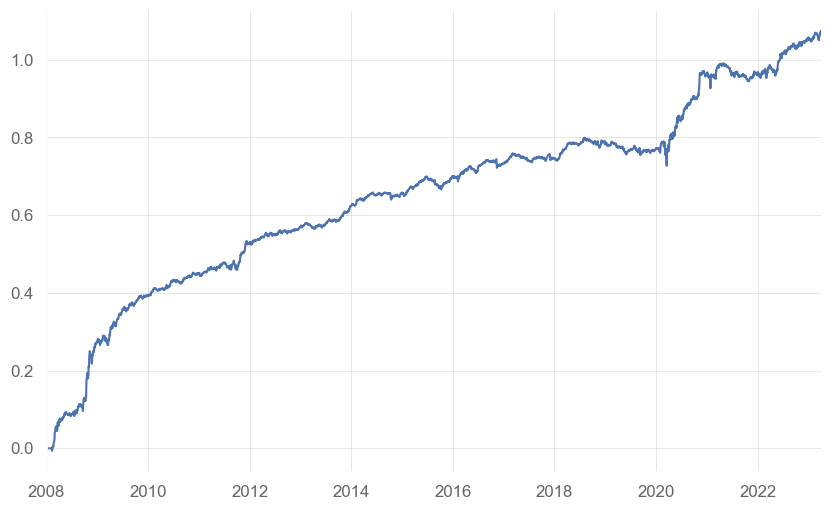

In [138]:
signal = results[P].ffill()
signal = signal[P].rolling(5).rank(axis=0,pct=True,ascending=False).clip(0.01,0.99) ## ts rank of the metrics on the last 5 trading days
## we rank it decreasing as we expect the metrics mean revert
signal = signal[P].rank(axis=1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf) ## cross sectionnal rank to avoid high/low price bias between stocks
signal[signal.abs()<1] = 0

signal = signal[P].groupby(GICS['gicsect'],axis=1).apply(center)
signal = signal[P].div(signal[P].abs().sum(1),0)

PNL = (signal[P].shift()*R).sum(1)
sr = sharpe(PNL)
turnover = signal.fillna(0).diff().abs().sum(1).mean()
PNL.cumsum().plot()
pd.Series({'Sharpe':sr,'Average Daily turnover (%)':turnover,'Average daily PNL (bp)':PNL.mean()*1e4}).round(1)

<Axes: >

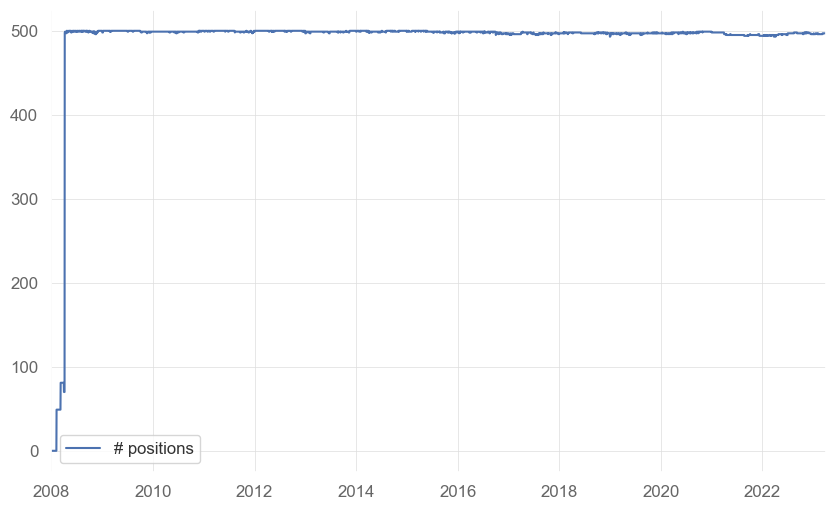

In [132]:
signal.count(1).plot(label ='# positions',legend=True)